![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [59]:
!pip install sweetviz

Defaulting to user installation because normal site-packages is not writeable


In [60]:
# Import necessary libraries
import mlflow
import sweetviz as sv
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import  matplotlib.pyplot as plt 
import seaborn as sns

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [61]:

cc_apps[13] = cc_apps[13].replace('+',1)
cc_apps[13] = cc_apps[13].replace('-',0)

In [62]:
report = sv.analyze(cc_apps,target_feat=13)

                                             |          | [  0%]   00:00 -> (? left)


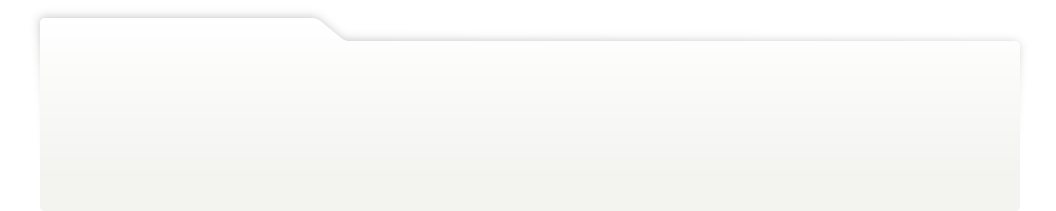
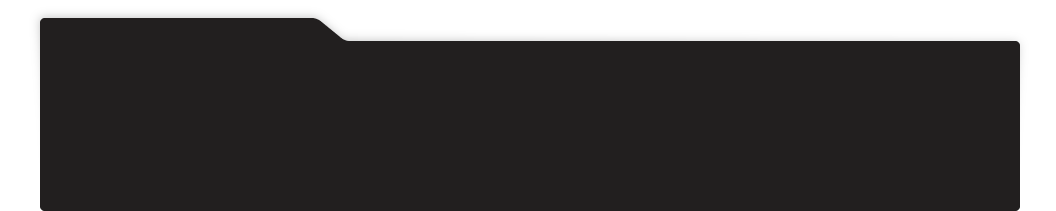
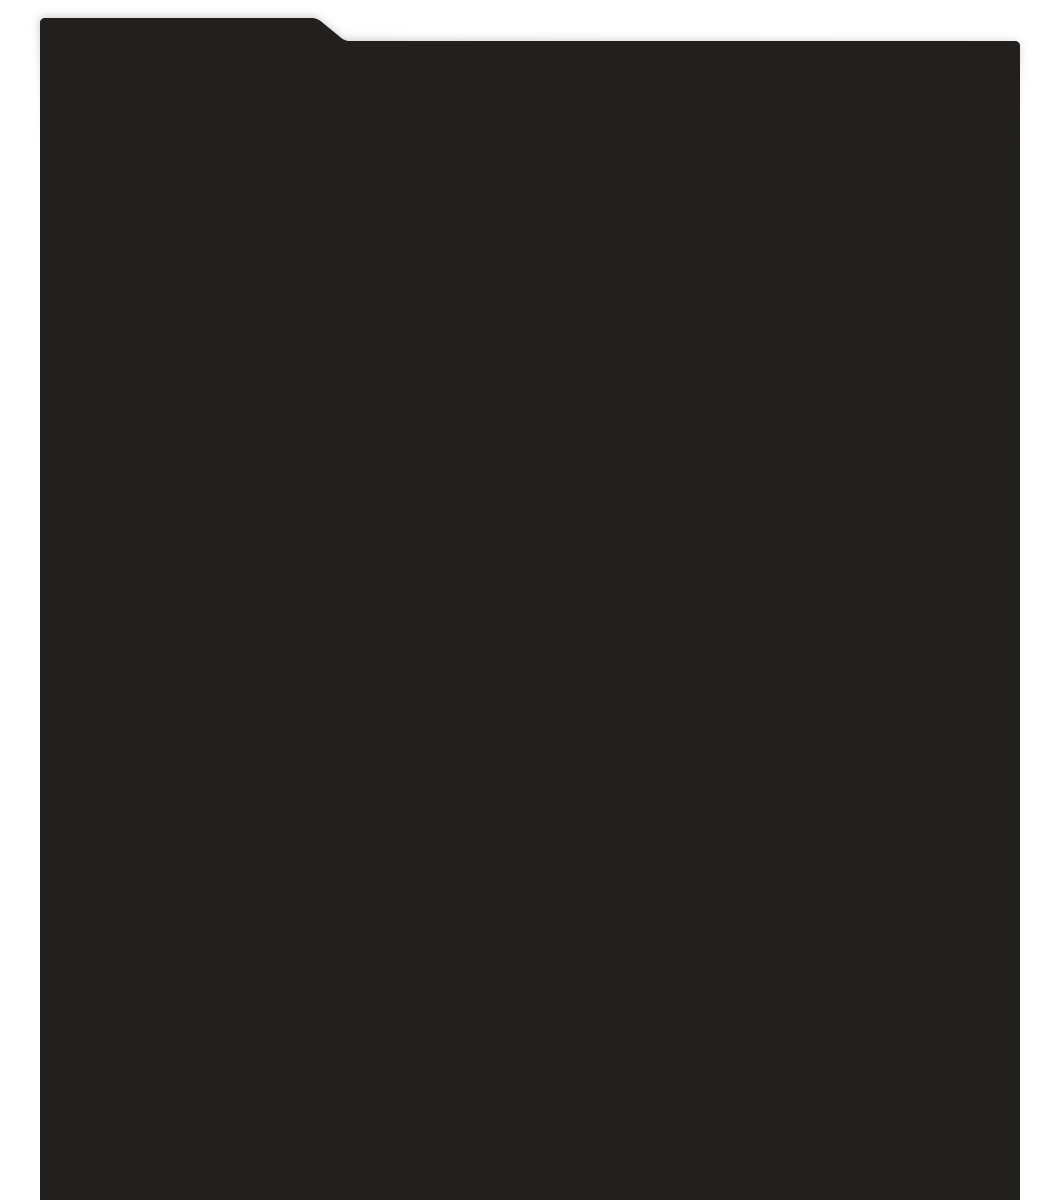
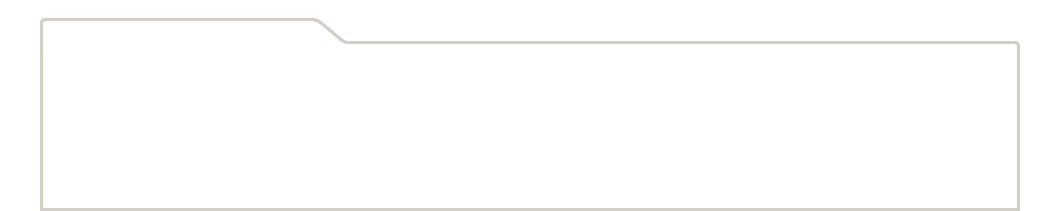
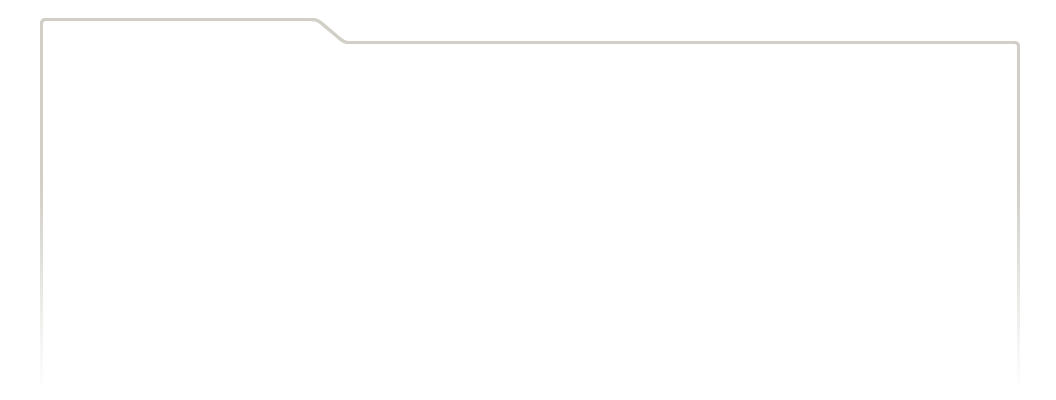
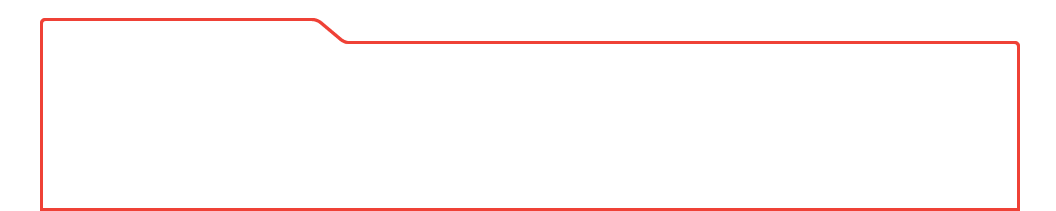
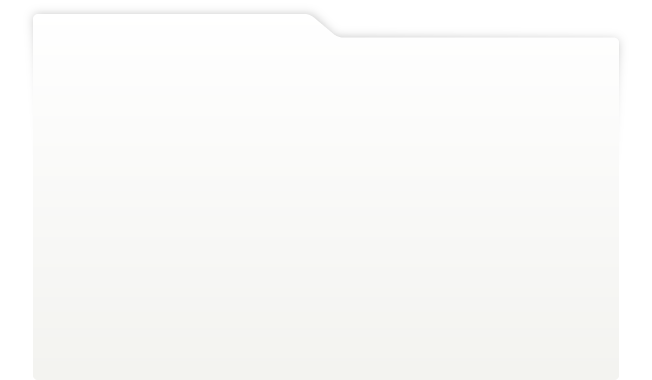
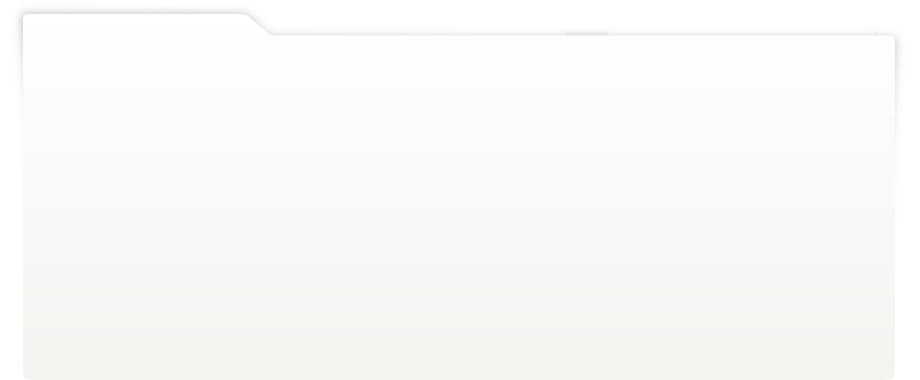
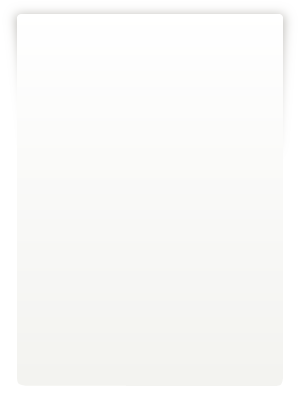
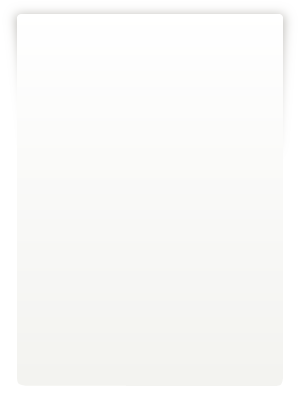
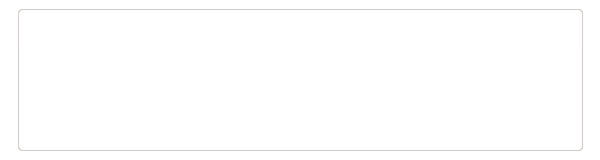
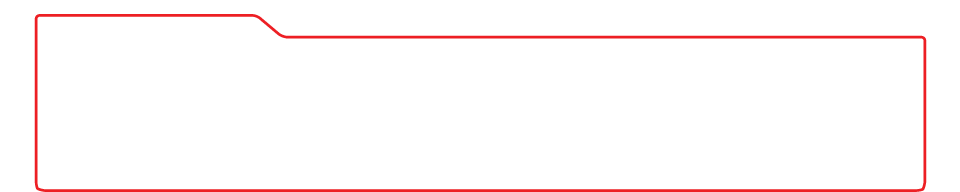
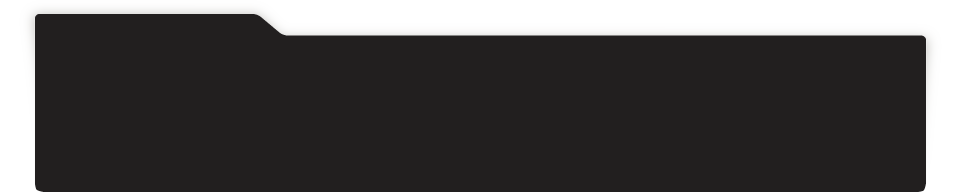
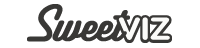
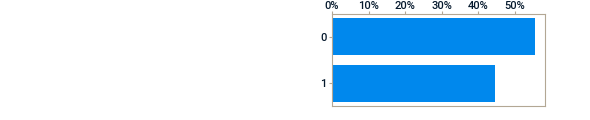
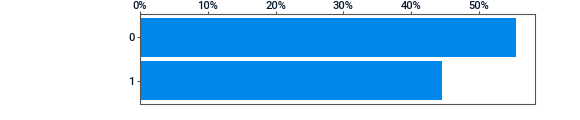
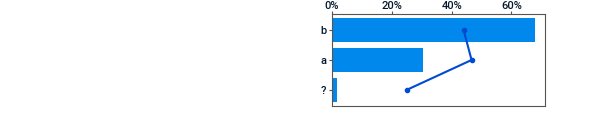
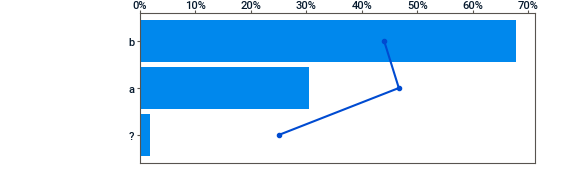
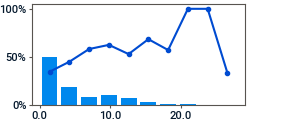
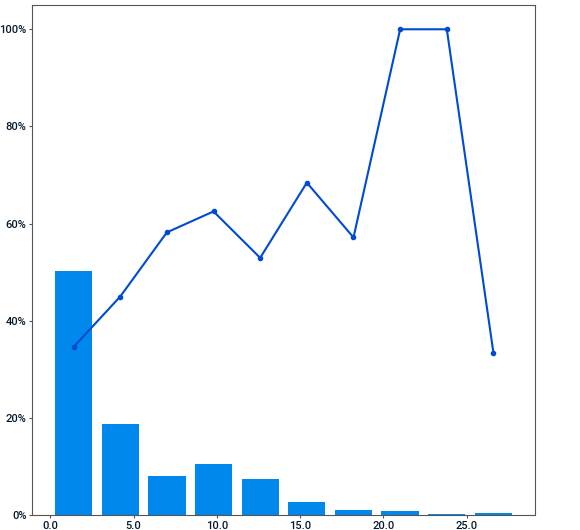
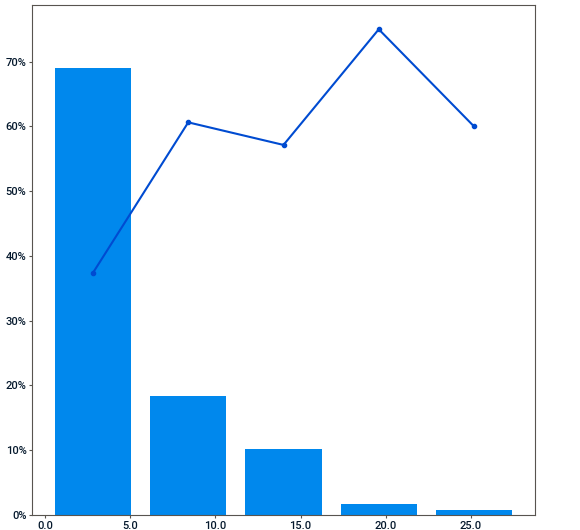
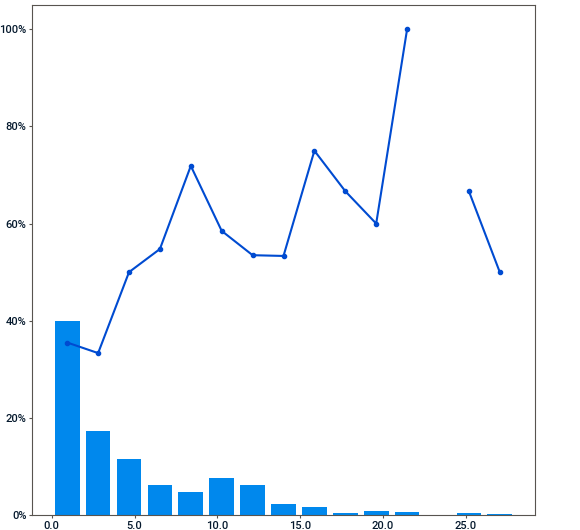
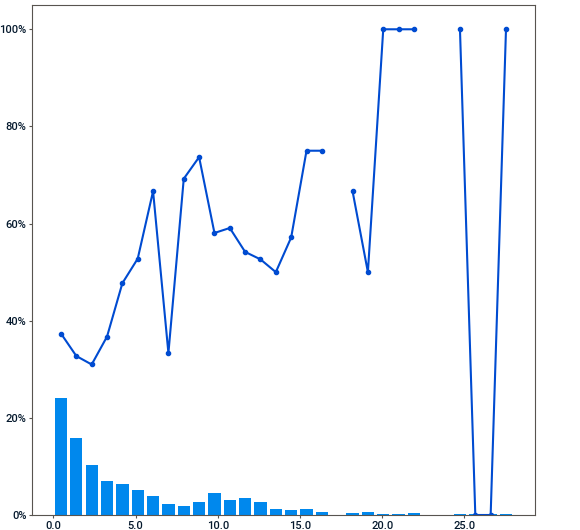
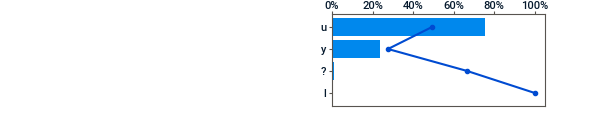
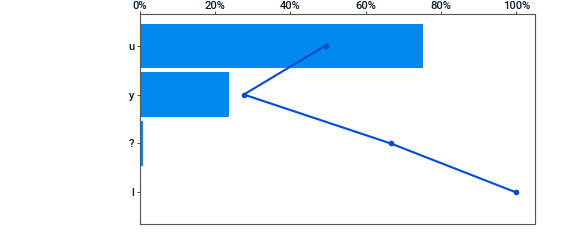
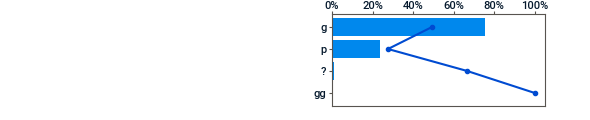
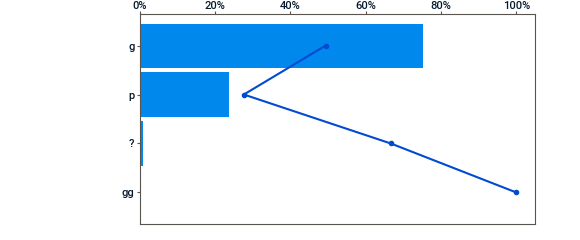
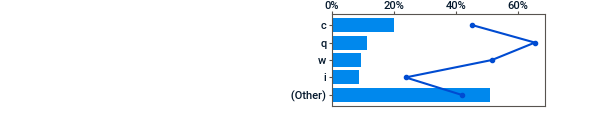
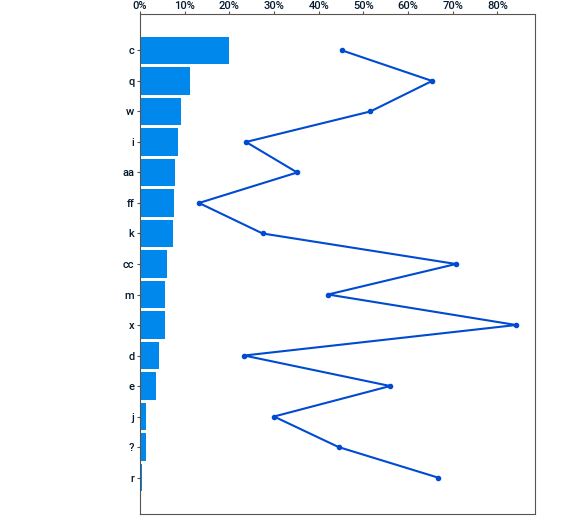
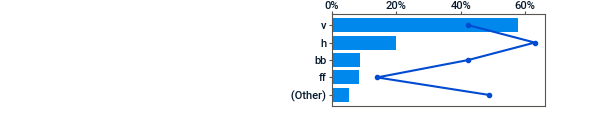
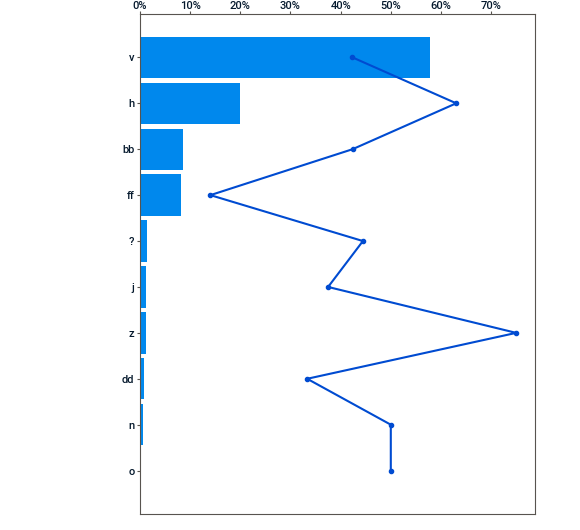
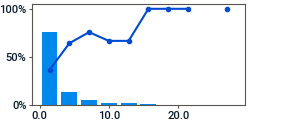
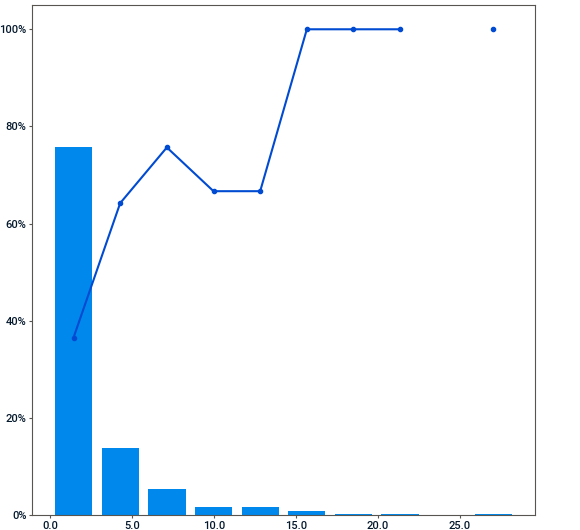
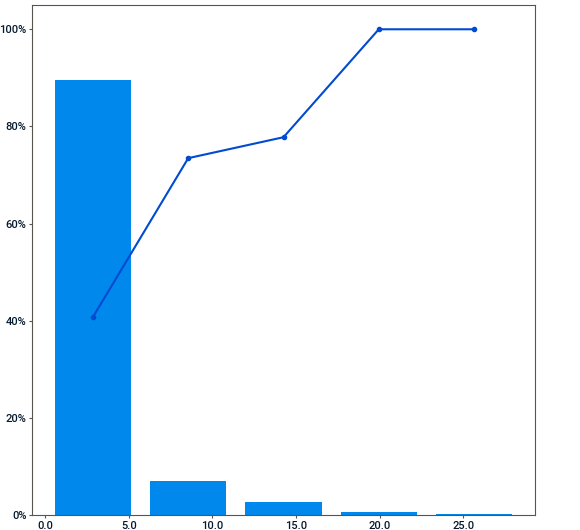
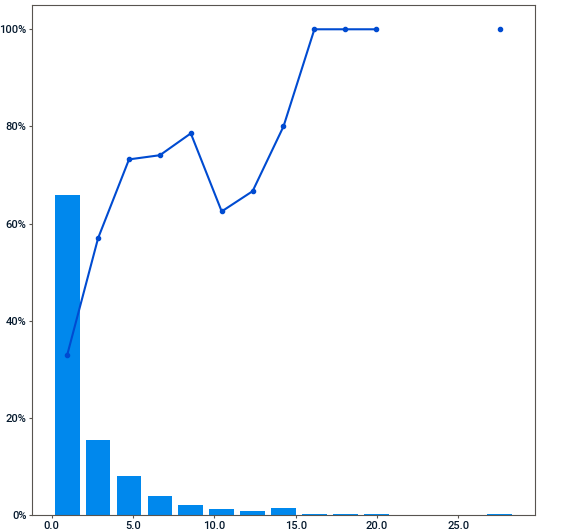
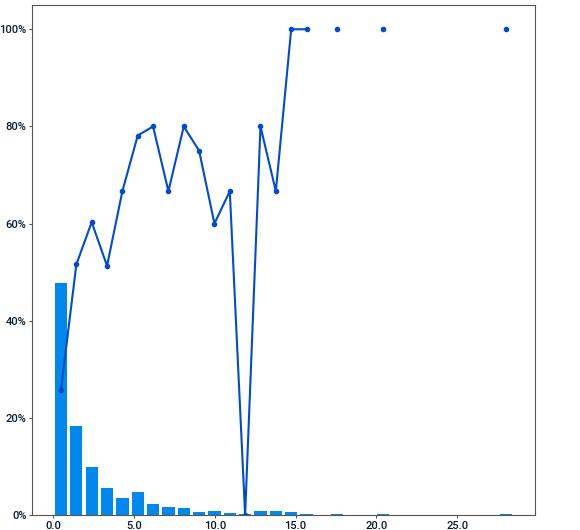
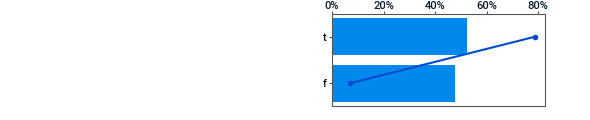
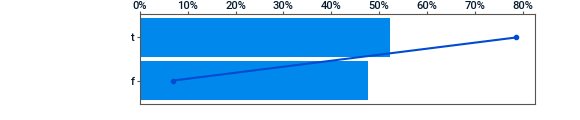
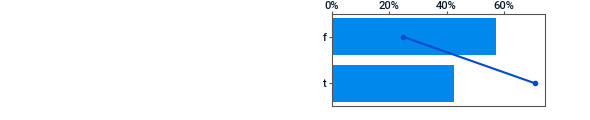
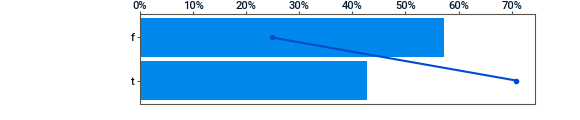
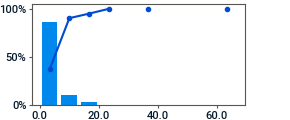
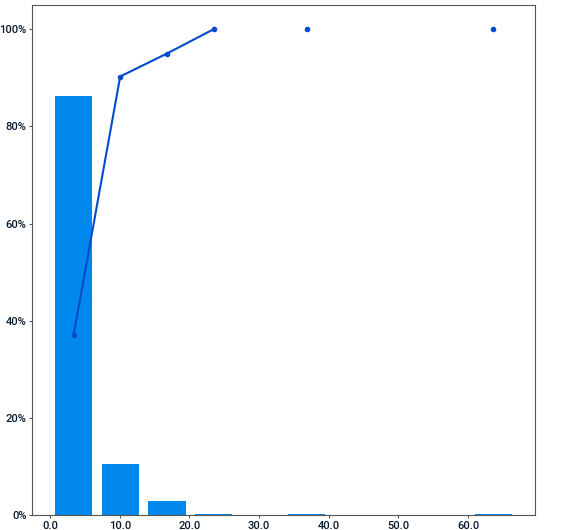
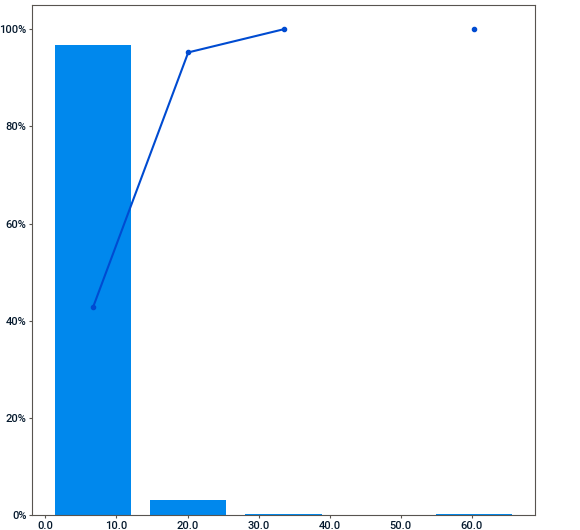
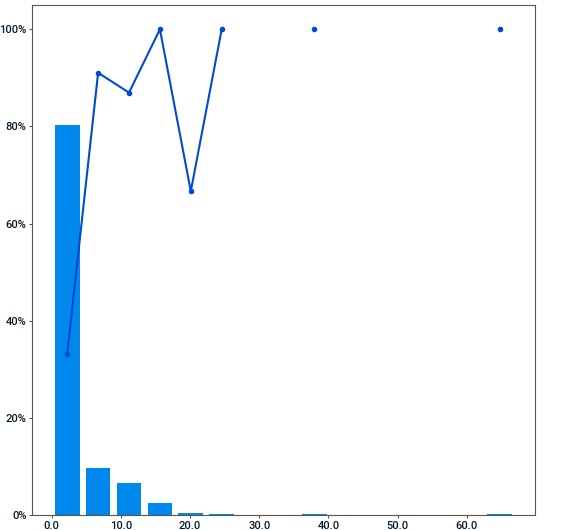
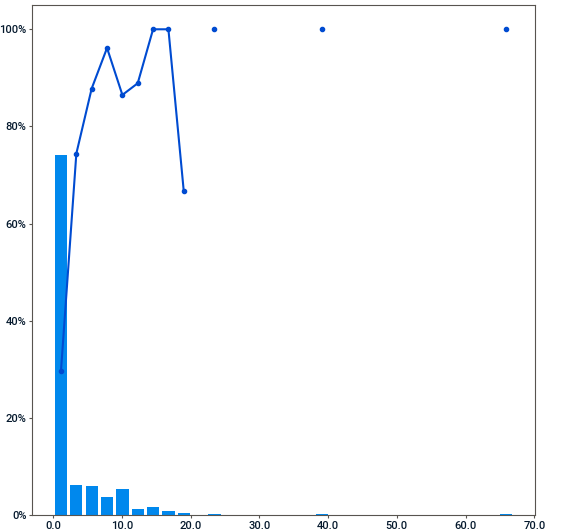
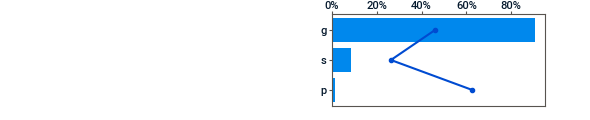
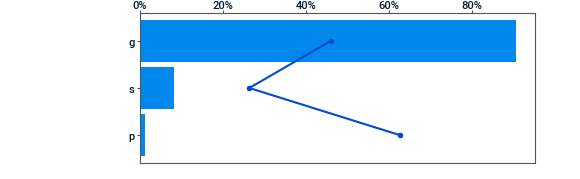
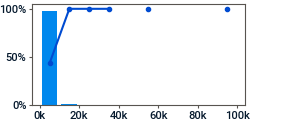
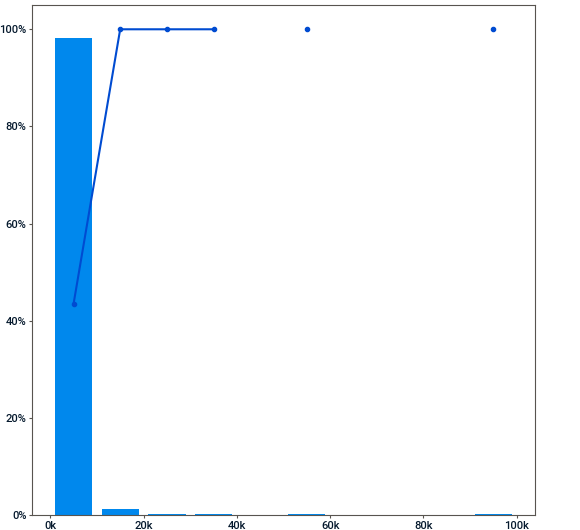
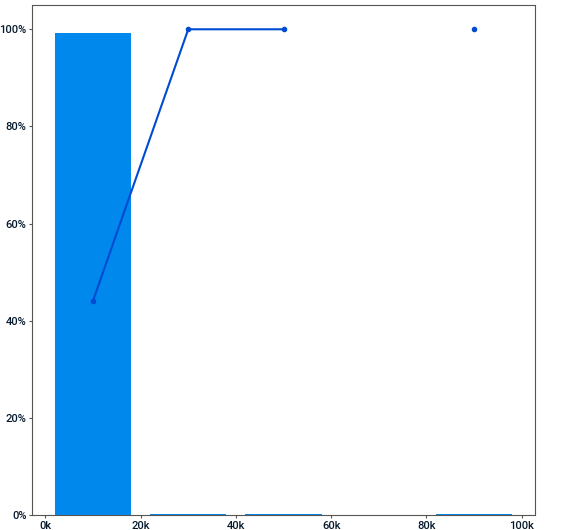
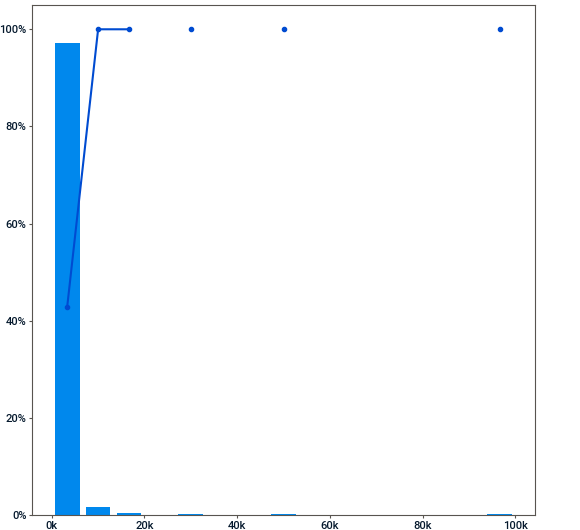
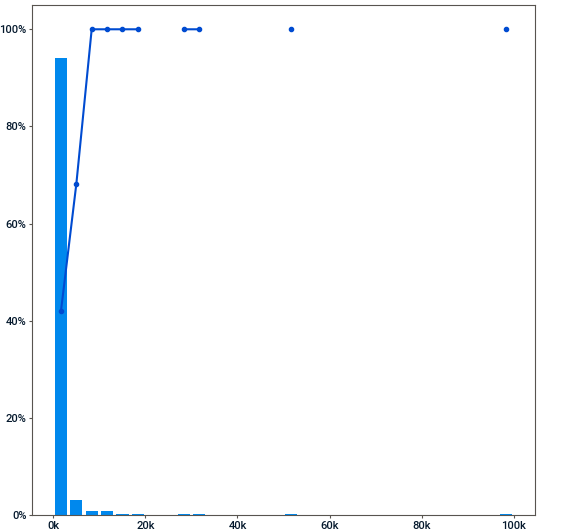
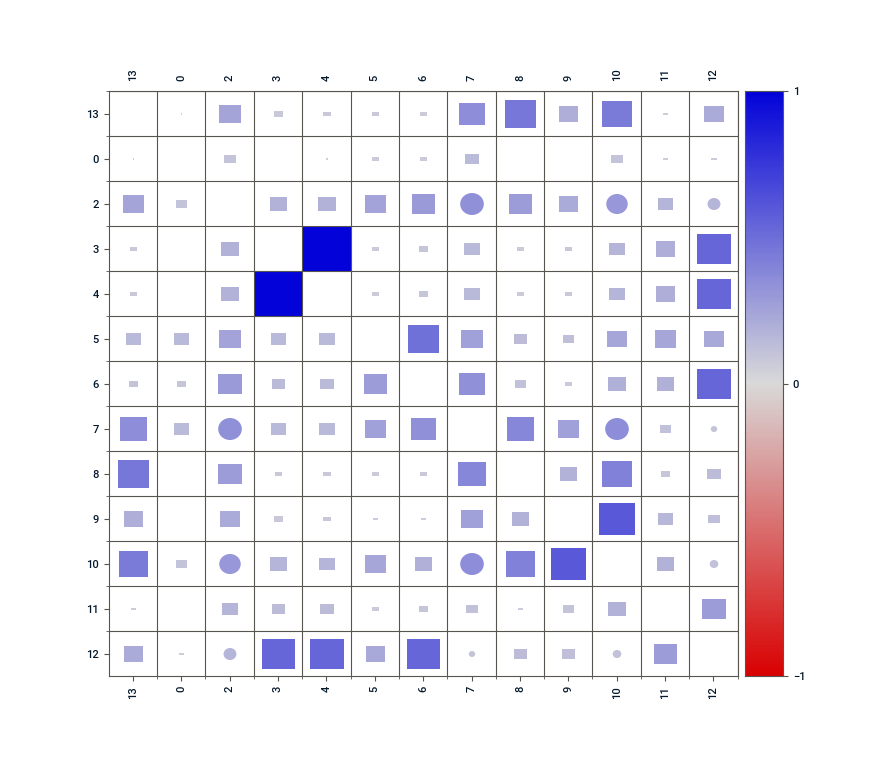
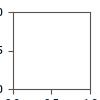

In [63]:
report.show_notebook()

In [64]:
cc_apps[0].unique()

array(['b', 'a', '?'], dtype=object)

In the dataset `cc_apps`, the column with index `1` contains some non-numeric values that need to be cleaned and converted to a numeric type for further analysis. Specifically, the column contains the characters `'?'` and `'f'`, which we will replace with `0`. After replacing these values, we will convert the entire column to the `float64` data type to ensure it is suitable for numerical operations.

Here is the code to perform these operations:

In [65]:
cc_apps[1]=cc_apps[1].replace('?',0)
cc_apps[1]=cc_apps[1].replace('f',0)
cc_apps[1] = cc_apps[1].astype('float64')


In [66]:
X = cc_apps[[2,7,8,9,10,12]]
y = cc_apps[13]
random_state = 12
max_iters =500
penalty = 'l2'
solver= 'newton-cholesky'
C= 0.03
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing and Model Training

In this section, we will define the preprocessing steps and create a pipeline to train a logistic regression model. The preprocessing steps will include scaling numeric features and encoding categorical features. We will then use this pipeline to fit the model on the training data and evaluate its performance on the test data.

In [67]:
# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [0,1,4,5]),  # Assuming columns 2 and 7 are numeric
        ('cat', OneHotEncoder(), [2,3])  # Add categorical columns here if needed
    ],
    remainder='passthrough'
)

# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(n_jobs=2, 
                                      random_state=random_state,
                                      max_iter=max_iters,
                                      penalty=penalty,
                                      solver=solver,
                                      C=C))
])

# Train the model
pipeline.fit(X_train.values, y_train.values)
score = pipeline.score(X_test, y_test)

# Experiment Tracking with MLflow

In this section, I will introduce MLflow, a powerful tool for managing the machine learning lifecycle, including experimentation, reproducibility, and deployment.

## What is MLflow?

MLflow is an open-source platform designed to manage the end-to-end machine learning lifecycle. It provides tools for:

- **Experiment Tracking**: Logging and querying experiments to record and compare parameters and results.
- **Model Management**: Packaging ML models in a format that can be easily shared and deployed.
- **Reproducibility**: Ensuring that experiments can be reproduced by capturing the environment and dependencies.
- **Deployment**: Simplifying the process of deploying models to various platforms.

## Using MLflow for Experiment Tracking

In my project, I used MLflow to track my experiments(different runs of my  ML model). This allowed me to log various metrics, such as accuracy and F1 score, and compare different runs to find the best model configuration. By tracking these experiments, I was able to iteratively improve my model until I was satisfied with its performance.

Here is an example of how you can use MLflow to track experiments:

```python
import mlflow
import mlflow.sklearn

# Start an MLflow run
with mlflow.start_run(nested=True):
    # Log parameters
    mlflow.log_param('n_jobs', 2)
    mlflow.log_param('random_state', random_state)
    
    mlflow.log_param('selected_features',X_train.columns.tolist())
    mlflow.log_param('max_iter', max_iters)
    mlflow.log_param('penalty',penalty)
    mlflow.log_param('solver',solver)
    mlflow.log_param('C',C)
    
    # Log metrics
    mlflow.log_metric('score', score)
    mlflow.log_artifact('confusion_matrix.png')

![image](image.png)


# Model Evaluation

After training our logistic regression model using the defined preprocessing pipeline, I evaluated its performance on the test dataset several times and saved those results to MLflow. After tweaking different parameters of the model, it achieved an accuracy score of **0.8406**. This indicates that the model correctly predicted the target variable for approximately 84% of the test samples. Below, I will delve deeper into the evaluation metrics to understand the model's performance in more detail.

In [68]:
score

0.8405797101449275

# Model Prediction and Evaluation

In this section, we will use the trained logistic regression model to make predictions on the test data. We will then evaluate the model's performance by generating a confusion matrix. The confusion matrix will be visualized using a heatmap with professional formatting to provide a clear and detailed view of the model's classification performance.

## How to Read and Interpret a Confusion Matrix

A confusion matrix is a table used to evaluate the performance of a classification model. It compares the actual target values with those predicted by the model. Here is a breakdown of the components of a confusion matrix:

- **True Positives (TP)**: The number of correct positive predictions.
- **True Negatives (TN)**: The number of correct negative predictions.
- **False Positives (FP)**: The number of incorrect positive predictions (Type I error).
- **False Negatives (FN)**: The number of incorrect negative predictions (Type II error).

The confusion matrix is typically structured as follows:

|                | Predicted Positive | Predicted Negative |
|----------------|--------------------|--------------------|
| **Actual Positive** | TP                 | FN                 |
| **Actual Negative** | FP                 | TN                 |

### Key Metrics Derived from the Confusion Matrix

- **Accuracy**: The proportion of true results (both true positives and true negatives) among the total number of cases examined.
  \[
  \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
  \]

- **Precision**: The proportion of positive identifications that were actually correct.
  \[
  \text{Precision} = \frac{TP}{TP + FP}
  \]

- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified.
  \[
  \text{Recall} = \frac{TP}{TP + FN}
  \]

- **F1 Score**: The harmonic mean of precision and recall.
  \[
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  \]

By analyzing these metrics, you can gain insights into the performance of your classification model and identify areas for improvement.

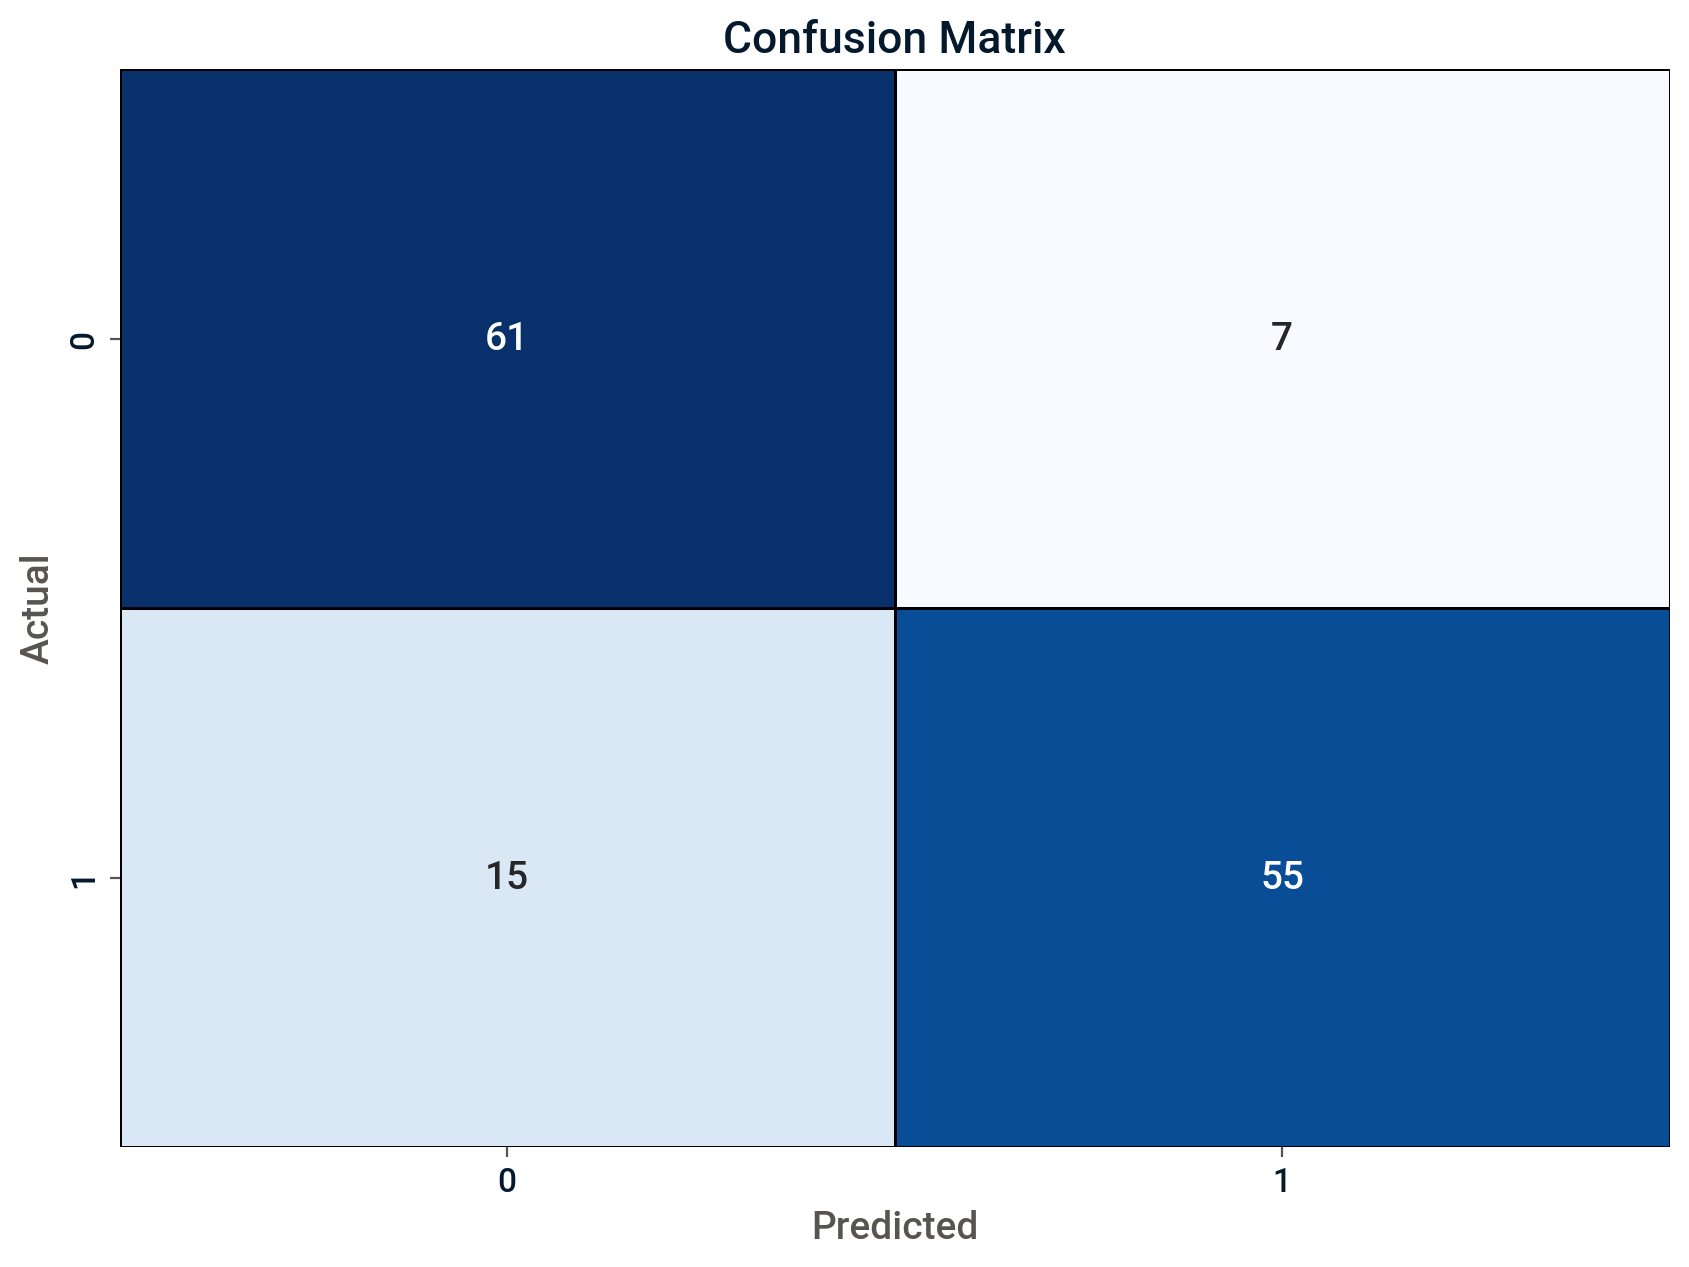

In [69]:
y_pred = pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with professional formatting
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            annot_kws={"size": 14}, linewidths=.5, linecolor='black')
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

The array `array([[61,  7], [15, 55]])` represents a confusion matrix, which is a performance measurement for machine learning classification problems. It is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

Here's a breakdown of the confusion matrix:

- **True Positives (TP)**: 61
  - The model correctly predicted the positive class.
- **False Positives (FP)**: 7
  - The model incorrectly predicted the positive class.
- **False Negatives (FN)**: 15
  - The model incorrectly predicted the negative class.
- **True Negatives (TN)**: 55
  - The model correctly predicted the negative class.

From this confusion matrix, we can calculate several performance metrics:

- **Accuracy**: (TP + TN) / (TP + TN + FP + FN)
  - Accuracy = (61 + 55) / (61 + 55 + 7 + 15) = 116 / 138 ≈ 0.84

- **Precision**: TP / (TP + FP)
  - Precision = 61 / (61 + 7) ≈ 0.90

- **Recall (Sensitivity)**: TP / (TP + FN)
  - Recall = 61 / (61 + 15) ≈ 0.80

- **F1 Score**: 2 * (Precision * Recall) / (Precision + Recall)
  - F1 Score = 2 * (0.90 * 0.80) / (0.90 + 0.80) ≈ 0.85

These metrics provide a comprehensive understanding of the model's performance.

Based on the confusion matrix provided, the model's performance can be evaluated using several key metrics:

1. **Accuracy**: This metric indicates the overall correctness of the model. It is calculated as the ratio of correctly predicted instances (both true positives and true negatives) to the total instances. The accuracy of the model is approximately 0.84, meaning the model correctly predicts the class 84% of the time.

2. **Precision**: This metric measures the accuracy of the positive predictions. It is calculated as the ratio of true positives to the sum of true positives and false positives. The precision of the model is approximately 0.90, indicating that when the model predicts a positive class, it is correct 90% of the time.

3. **Recall (Sensitivity)**: This metric measures the model's ability to correctly identify positive instances. It is calculated as the ratio of true positives to the sum of true positives and false negatives. The recall of the model is approximately 0.80, meaning the model correctly identifies 80% of the actual positive instances.

4. **F1 Score**: This metric is the harmonic mean of precision and recall, providing a balance between the two. It is particularly useful when the class distribution is imbalanced. The F1 score of the model is approximately 0.85, indicating a good balance between precision and recall.

In summary, the model demonstrates strong performance with high precision and a good balance between precision and recall, as indicated by the F1 score. The accuracy of 84% suggests that the model is generally reliable in its predictions.

In [70]:
best_score = score